In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', 50)


# Envigado

## Importación y limpieza

In [ ]:
df_envigado = pd.read_csv("https://www.datos.gov.co/api/views/t5sw-amxr/rows.csv?accessType=DOWNLOAD")

#funcion ajustar hora
def ajuste_hora(ch,h):
  if h is not np.nan:
    if ch=='p.m.':
      if int(h)!=12:
        h=int(h)+12
      else:
        h=h
    else:
      if int(h)!=12:
        h=h
      else:
        h='0'
  else:
    h=h
  return h
#fin funcion


df_envigado['HORA'].replace({'sin información':np.nan},inplace=True)
df_envigado['ch'] = df_envigado['HORA'].str.split(' ').str[1]
df_envigado['h'] = df_envigado['HORA'].str.split(' ').str[0].str.split(':').str[0]
df_envigado['HORA_AJUSTADA'] = df_envigado.apply(lambda x: ajuste_hora(x['ch'],x['h']), axis=1)

#Funcion ajustar fecha
def ajuste_fecha(x0,x1,x2,dow):
  import datetime as dt
  if x0>12 and x1>12:
    dia = 1
    mes = 1
    ano = 1900
  elif x0>12 and x1<=12:
    dia = x0
    mes = x1
    ano = x2
  elif x0<=12 and x1>12:
    dia = x1
    mes = x0
    ano = x2
  else:
    if  dow == dt.date(x2,x1,x0).weekday()+1:
      dia = x1
      mes= x0
      ano = x2
    elif  dow == dt.date(x2,x0,x1).weekday()+1:
      dia = x0
      mes = x1
      ano = x2
    else:
      dia = 1
      mes = 1
      ano = 1900
  #print(dia,'-',mes,'-',ano)
  fecha = dt.date(ano,mes,dia)
  return fecha
#fin funcion

df_envigado['FECHA_AJUSTADA'] = df_envigado['FECHA'].str.split('/')
df_envigado['v0'] = (df_envigado['FECHA'].str.split('/').str[0]).astype(int)
df_envigado['v1'] = (df_envigado['FECHA'].str.split('/').str[1]).astype(int)
df_envigado['v2'] = ('20'+df_envigado['FECHA_AJUSTADA'].str[2].str[-2:]).astype(int)
df_envigado['dow'] = df_envigado['DÍA DE LA SEMANA'].replace({'Lunes':1,'Martes':2,'Miércoles':3,'Jueves':4,'Viernes':5,'Sábado':6,'Domingo':7})
df_envigado['FECHA_AJUSTADA'] = df_envigado.apply(lambda x: ajuste_fecha(x['v0'],x['v1'],x['v2'],x['dow']),axis=1)
df_envigado.drop(['v0','v1','v2'], axis=1, inplace=True)

df_envigado['GRAVEDAD'].replace({'Herido':'Heridos','Muerto':'Muertos'},inplace=True)
df_envigado['GRAVEDAD'].value_counts(dropna=False)

df_envigado['Heridos'] = pd.get_dummies(df_envigado['GRAVEDAD'])['Heridos']
df_envigado['Cuenta Heridos'] = np.nan
df_envigado['Muertos'] = pd.get_dummies(df_envigado['GRAVEDAD'])['Muertos']
df_envigado['Cuenta Muertos'] = np.nan

df_envigado['Ciudad'] = 'Envigado'

df = df_envigado.copy(deep=True)
df= df[['FECHA_AJUSTADA','dow','Coordenadas','Ciudad','Heridos','Cuenta Heridos','Muertos','Cuenta Muertos','CLASE DE ACCIDENTE','HORA_AJUSTADA']]
df.rename(columns={'FECHA_AJUSTADA':'Fecha',
                   'dow':'DOW',
                   #'Coordenadas',
                   #'Ciudad','Heridos',
                   #'Cuenta Heridos',
                   #'Muertos',
                   #'Cuenta Muertos',
                   'CLASE DE ACCIDENTE':'Clase accidente',
                   'HORA_AJUSTADA':'Hora'},inplace=True)

df.to_csv('envigado_clean.csv',index=False)

df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Fecha,DOW,Coordenadas,Ciudad,Heridos,Cuenta Heridos,Muertos,Cuenta Muertos,Clase accidente,Hora
0,2016-01-01,5,"(6174101275, -7558360607)",Envigado,1,NaN,0,NaN,Choque,13
1,2016-01-01,5,"(6174101275, -7558360607)",Envigado,1,NaN,0,NaN,Choque,13
2,2016-03-01,7,NaN,Envigado,0,NaN,0,NaN,Choque,23


## Analisis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37005 entries, 0 to 37004
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fecha            37005 non-null  object 
 1   DOW              37005 non-null  int64  
 2   Coordenadas      29092 non-null  object 
 3   Ciudad           37005 non-null  object 
 4   Heridos          37005 non-null  uint8  
 5   Cuenta Heridos   0 non-null      float64
 6   Muertos          37005 non-null  uint8  
 7   Cuenta Muertos   0 non-null      float64
 8   Clase accidente  37005 non-null  object 
 9   Hora             19623 non-null  object 
dtypes: float64(2), int64(1), object(5), uint8(2)
memory usage: 2.3+ MB


In [ ]:

base = df.groupby(['DOW'])['Ciudad'].count().reset_index().rename(columns={'Ciudad':'Cuenta'})

fig = px.bar(base, x='DOW', y='Cuenta',title='Cuenta de Accidentes por día de la semana',width=800, height=400)

fig.show()

In [ ]:
base = df.groupby(df['Hora'])['Ciudad'].count().reset_index().rename(columns={'Ciudad':'Cuenta'})

fig = px.bar(base, x='Hora', y='Cuenta',width=800, height=400)
fig.update_xaxes(dtick=1)
fig.show()

In [ ]:
base = df.groupby([pd.to_datetime(df['Fecha']).dt.month.astype('str'),df['DOW'].astype(str)])['Heridos'].sum().reset_index().rename(columns={'Fecha':'Mes'})

fig = px.bar(base, x='Mes', y='Heridos',color='DOW',title='Accidentes por mes y DOW')
fig.update_layout(barmode='group',width=800, height=400)
fig.show()

# Barranquilla

In [ ]:
#Barranquilla 1
df_bq1 = pd.read_csv("https://www.datos.gov.co/api/views/yb9r-2dsi/rows.csv?accessType=DOWNLOAD")
# reemplazar nan por 0 y convertir a entero
df_bq1["CANT_HERIDOS_EN _SITIO_ACCIDENTE"] = df_bq1["CANT_HERIDOS_EN _SITIO_ACCIDENTE"].replace(np.NaN,0).astype(int)
# reemplazar nan por 0 y convertir a entero
df_bq1["CANT_MUERTOS_EN _SITIO_ACCIDENTE"] = df_bq1["CANT_MUERTOS_EN _SITIO_ACCIDENTE"].replace(np.NaN,0).astype(int)
# volver columna a datetime
df_bq1["FECHA_ACCIDENTE"] = pd.to_datetime(df_bq1["FECHA_ACCIDENTE"])
# convertir a entero
df_bq1["CANTIDAD_ACCIDENTES"] = df_bq1["CANTIDAD_ACCIDENTES"].astype(int)
# Extraer hora
df_bq1["HORA_ACCIDENTE"].str.split(':').str[0]
# Ajustar hora AM/PM
def ajuste_hora(ch,h):
  if h is not np.nan:
    if ch=='PM':
      if int(h)!=12:
        h=int(h)+12
      else:
        h=h
    else:
      if int(h)!=12:
        h=h
      else:
        h='0'
  else:
    h=h
  return h

# convertir hora a 24h
df_bq1['ch'] = df_bq1['HORA_ACCIDENTE'].str.split(':').str[3]
df_bq1['h'] = df_bq1['HORA_ACCIDENTE'].str.split(':').str[0]
df_bq1['HORA_AJUSTADA'] = df_bq1.apply(lambda x: ajuste_hora(x['ch'],x['h']), axis=1)


In [ ]:
horas = df_bq1[['ch','h',]].value_counts().reset_index().sort_values('ch')
horas.loc[horas['h']=='12',]

,ch,h,0
19,AM,12,384
0,PM,12,3004


0        14
1        14
2        14
3        15
4        04
         ..
40379    10
40380    11
40381    23
40382    23
40383     0
Length: 40384, dtype: object

In [ ]:
df_bq1.groupby("AÑO_ACCIDENTE")["CANTIDAD_ACCIDENTES"].sum().reset_index()
fig = px.histogram(df_bq1, x="AÑO_ACCIDENTE", y="CANTIDAD_ACCIDENTES", title='Cantidad de accidentes por año')
fig.update_layout(bargap=0.2,width=800, height=400)
fig.show()

In [ ]:
df_bq1.groupby(["AÑO_ACCIDENTE"])["CANT_HERIDOS_EN _SITIO_ACCIDENTE"].sum().reset_index()

,AÑO_ACCIDENTE,CANT_HERIDOS_EN _SITIO_ACCIDENTE
0,2015,1084
1,2016,1012
2,2017,1242
3,2018,2541
4,2019,2217
5,2020,1543
6,2021,2088
7,2022,858


In [ ]:
a = df_bq1.groupby(["AÑO_ACCIDENTE"])["CANT_HERIDOS_EN _SITIO_ACCIDENTE"].sum().reset_index()
fig2 = px.bar(a, x="AÑO_ACCIDENTE", y="CANT_HERIDOS_EN _SITIO_ACCIDENTE",title='Cantidad de heridos por año',width=800, height=400)
fig2.show()

In [ ]:
b=df_bq1.groupby(["AÑO_ACCIDENTE"])["CANT_MUERTOS_EN _SITIO_ACCIDENTE"].sum().reset_index()
fig3 = px.bar(b, x="AÑO_ACCIDENTE", y="CANT_MUERTOS_EN _SITIO_ACCIDENTE",title='Cantidad de muertos por año',width=800, height=400)
fig3.show()

In [ ]:
c=df_bq1.groupby(["DIA_ACCIDENTE"])["CANTIDAD_ACCIDENTES"].sum().reset_index()
fig4 = px.bar(c, x="DIA_ACCIDENTE", y="CANTIDAD_ACCIDENTES",title='Cantidad de accidentes por día',color='DIA_ACCIDENTE',width=800, height=400)
fig4.show()

In [ ]:
d=df_bq1.groupby(["HORA_AJUSTADA"])["CANTIDAD_ACCIDENTES"].sum().reset_index()
fig5 = px.bar(d, x="HORA_AJUSTADA", y="CANTIDAD_ACCIDENTES",title='Cantidad de accidentes por hora',color='HORA_AJUSTADA',width=800, height=400)
fig5.show()

In [ ]:
#Barranquilla 2
df_bq2 = pd.read_csv("https://www.datos.gov.co/api/views/nfa3-wgxy/rows.csv?accessType=DOWNLOAD")
df_bq2

,AÑO_ACCIDENTE,MES_ACCIDENTE,CLASE ACCIDENTE,SERVICIO_VEHICULO_ACCIDENTADO,CLASE_VEHICULO_ACCIDENTADO,CANTIDAD_VEHICULOS
0,2015,1,Atropello,PARTICULAR,AUTOMOVIL,3
1,2015,1,Atropello,PARTICULAR,MOTOCICLETA,5
2,2015,1,Atropello,PUBLICO,AUTOMOVIL,2
3,2015,1,Atropello,PUBLICO,BUS,1
4,2015,1,Atropello,PUBLICO,BUSETA,1
...,...,...,...,...,...,...
3073,2022,4,Choque,PUBLICO,CAMIONETA,11
3074,2022,4,Choque,PUBLICO,MICROBUS,2
3075,2022,4,Choque,PUBLICO,TRACTO/CAMION,20
3076,2022,4,Choque,PUBLICO,VOLQUETA,7


In [ ]:
df_bq2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3078 entries, 0 to 3077
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   AÑO_ACCIDENTE                  3078 non-null   int64 
 1   MES_ACCIDENTE                  3078 non-null   int64 
 2   CLASE ACCIDENTE                3078 non-null   object
 3   SERVICIO_VEHICULO_ACCIDENTADO  3078 non-null   object
 4   CLASE_VEHICULO_ACCIDENTADO     3078 non-null   object
 5   CANTIDAD_VEHICULOS             3078 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 144.4+ KB


In [ ]:
df_bq2["SERVICIO_VEHICULO_ACCIDENTADO"].value_counts()

PUBLICO        1239
PARTICULAR     1135
OFICIAL         344
OTROS           338
DIPLOMATICO      17
No Aplica         4
ESPECIAL          1
Name: SERVICIO_VEHICULO_ACCIDENTADO, dtype: int64

In [ ]:
df_bq2["CLASE_VEHICULO_ACCIDENTADO"].value_counts()

AUTOMOVIL                    566
MOTOCICLETA                  442
CAMIONETA                    380
BUS                          279
CAMION                       274
CAMPERO                      194
VOLQUETA                     181
TRACTO/CAMION                172
BUSETA                       168
MICROBUS                     154
BICICLETA O TRICICLO         104
OTROS                         41
TRACCION ANIMAL               38
MOTOCARRO                     31
MAQUINARIA INDUSTRIAL         17
MAQUINARIA AGRICOLA            5
CUATRIMOTO                     4
MINICARGADOR                   4
RETROEXCAVADORA                4
MONTACARGAS                    3
REMOLQUE                       2
CICLOMOTOR                     2
CARRETILLA ELEVADORA           1
SEMIREMOLQUE                   1
DUMPER VOLQUETAARTICULADA      1
CAMION (RNMA)                  1
MOTOTRICICLO                   1
MINI EXCAVADORA                1
BULDOZER                       1
MANIPULADOR TELESCOPICO        1
PLATAFORMA

In [ ]:
e = df_bq2.groupby(["AÑO_ACCIDENTE"])["CANTIDAD_VEHICULOS"].sum().reset_index()
fig6 = px.bar(e, x="AÑO_ACCIDENTE", y="CANTIDAD_VEHICULOS",title='Cantidad de vehículos accidentados por año',width=800, height=400)
fig6.show()

In [ ]:
#Barranquilla 3
df_bq3 = pd.read_csv("https://www.datos.gov.co/api/views/y628-5q9a/rows.csv?accessType=DOWNLOAD")
df_bq3

,AÑO_ACCIDENTE,MES_ACCIDENTE,CONDICION_VICTIMA,GRAVEDAD_ACCIDENTE,CLASE_ACCIDENTE,SEXO_VICTIMA,EDAD_VICTIMA,CANTIDAD_VICTIMAS
0,2015,1,Acompañante,herido,Choque,F,13,1
1,2015,1,Acompañante,herido,Choque,F,37,1
2,2015,1,Acompañante,herido,Choque,F,62,1
3,2015,1,Acompañante,herido,Choque,M,36,1
4,2015,1,Acompañante,herido,Choque,M,66,1
...,...,...,...,...,...,...,...,...
9758,2022,4,Peaton,herido,Atropello,M,58,1
9759,2022,4,Peaton,herido,Atropello,M,62,1
9760,2022,4,Peaton,herido,Atropello,M,65,1
9761,2022,4,Peaton,herido,Atropello,M,71,1


In [ ]:
df_bq3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9763 entries, 0 to 9762
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AÑO_ACCIDENTE       9763 non-null   int64 
 1   MES_ACCIDENTE       9763 non-null   int64 
 2   CONDICION_VICTIMA   9763 non-null   object
 3   GRAVEDAD_ACCIDENTE  9763 non-null   object
 4   CLASE_ACCIDENTE     9763 non-null   object
 5   SEXO_VICTIMA        9723 non-null   object
 6   EDAD_VICTIMA        9763 non-null   int64 
 7   CANTIDAD_VICTIMAS   9763 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 610.3+ KB


In [ ]:
df_bq3["CONDICION_VICTIMA"].value_counts()

Motociclista    2941
Pasajero        2237
Acompañante     1598
Peaton          1535
Conductor       1096
Ciclista         344
Otros             12
Name: CONDICION_VICTIMA, dtype: int64

In [ ]:
df_bq3["GRAVEDAD_ACCIDENTE"].value_counts()

herido    9488
muerto     275
Name: GRAVEDAD_ACCIDENTE, dtype: int64

In [ ]:
df_bq3["CLASE_ACCIDENTE"].value_counts()

Choque            7486
Atropello         1800
Caida Ocupante     193
Otro               133
Volcamiento        131
Incendio            20
Name: CLASE_ACCIDENTE, dtype: int64

In [ ]:
f=df_bq3.groupby(["AÑO_ACCIDENTE"])["CANTIDAD_VICTIMAS"].sum().reset_index()
fig7 = px.bar(f, x="AÑO_ACCIDENTE", y="CANTIDAD_VICTIMAS",title='Cantidad de víctimas año',width=800, height=400)
fig7.show()

# Nacional

In [ ]:
pd.set_option('display.max_columns', 50)

In [3]:
df_col = pd.read_csv("https://www.datos.gov.co/api/views/jj5k-4x95/rows.csv?accessType=DOWNLOAD")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_col.head(1)

,objectid,codigo,territorial,amv,fecha_registro,codigo_via,pr,distancia_pr,fecha_acc,dia_semana_acc,min_acc,condic_meteor,estado_super,terreno,secc_tip,geometria_acc,tipo_cierre,horas_cierre,min_cierre,n_heridos,n_muertos,n_victimas,clase_accidente,causa_posible,procedencia,revisado_por,ref_met,ref_loc,ref_off,to_date,from_date,meas,eventid,ruta_id,LocError,lado,hora_acc,n_heridos 1,fuente,observa,Causa_old
0,36801,75030,San Andres y Providencia,SAP1,2018-03-06 16:52,0101,22,900.0,2018-02-25 5:00,domingo,3,Seca,Seca y limpia,Plano,Terraplen,Recta,Transito normal con precaución,0,0,2,0,NaN,Choque,Reverso imprudente,NaN,HUDSON ROBINSON HOOKER,Poste_Ref,0101_0_22,900.0,NaN,2016-12-22 15:29,23072.60384,acc_hermes75030,0101_0,NO ERROR,1,NaN,NaN,NaN,NaN,Impericia en el manejo


In [ ]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18553 entries, 0 to 18552
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   objectid         18553 non-null  int64  
 1   codigo           18553 non-null  int64  
 2   territorial      18553 non-null  object 
 3   amv              18552 non-null  object 
 4   fecha_registro   18544 non-null  object 
 5   codigo_via       18553 non-null  object 
 6   pr               18553 non-null  int64  
 7   distancia_pr     18553 non-null  float64
 8   fecha_acc        18553 non-null  object 
 9   dia_semana_acc   18553 non-null  object 
 10  min_acc          18553 non-null  int64  
 11  condic_meteor    18553 non-null  object 
 12  estado_super     18553 non-null  object 
 13  terreno          18553 non-null  object 
 14  secc_tip         18553 non-null  object 
 15  geometria_acc    18553 non-null  object 
 16  tipo_cierre      18553 non-null  object 
 17  horas_cierre

In [ ]:
df_col['territorial'].value_counts()

Planta Central              2847
Antioquia                   2058
Valle del Cauca             1988
Boyacá                      1632
Risaralda                   1456
Nariño                       870
Caldas                       851
Cauca                        754
Santander                    686
Quindío                      651
Casanare                     651
Cundinamarca                 574
Tolima                       499
Córdoba                      467
Norte de Santander           420
Caquetá                      394
Putumayo                     367
Cesar                        276
Huila                        239
Meta                         169
Ocaña                        164
Guajira                      117
Sucre                        116
Chocó                         96
San Andres y Providencia      81
Bolívar                       79
Magdalena                     47
Atlántico                      4
Name: territorial, dtype: int64

In [ ]:
df_col['dia_semana_acc'].value_counts()

Domingo      1827
Sábado       1804
Viernes      1643
Jueves       1626
Miércoles    1542
Martes       1527
Lunes        1523
sabado       1120
domingo      1043
viernes      1034
lunes        1007
jueves        993
miercoles     969
martes        895
Name: dia_semana_acc, dtype: int64

In [ ]:
dict_dia = {'lunes': 'Lunes','martes': 'Martes','miercoles': 'Miercoles', 'Miércoles': 'Miercoles', 'jueves': 'Jueves','viernes': 'Viernes',
'Sábado':'Sabado', 'sabado':'Sabado','domingo' : 'Domingo'}


In [ ]:
df_col["dia_semana"] = df_col["dia_semana_acc"].replace(dict_dia)

In [ ]:
base = df_col.groupby(by=['fecha_acc'])['objectid'].count().reset_index().rename(columns={'objectid':'Cuenta'})
base = base.loc[base['fecha_acc']>'2000-01-01',]
fig = px.line(base, x='fecha_acc', y="Cuenta",width=800, height=400)
fig.show()

In [ ]:
base = df_col.groupby(['dia_semana'])['territorial'].count().reset_index().rename(columns={'territorial':'Cuenta'})

fig = px.bar(base, x='dia_semana', y='Cuenta',title='Cuenta de Accidentes día de la semana por departamento',width=800, height=400)

fig.show()

# Palmira

In [ ]:
df_palmira = pd.read_csv("https://www.datos.gov.co/api/views/mg8y-amuh/rows.csv?accessType=DOWNLOAD")

In [ ]:
columnas=["Fecha","Hora","DOW","Coordenadas","Ciudad","Heridos","Cuenta Heridos","Muertos","Cuenta Muertos","Clase accidente","Barrio","Tipo de Vehiculo"]
df_palmira_clean = pd.DataFrame(columns=columnas)

In [ ]:
df_palmira_clean["Fecha"]=pd.to_datetime(df_palmira["FECHA"].str[:10])
df_palmira_clean["Hora"]=pd.to_datetime(df_palmira["HORA"]).dt.hour
df_palmira_clean["DOW"]=df_palmira_clean["Fecha"].dt.dayofweek+1
df_palmira_clean["Coordenadas"]=df_palmira["LAT"].astype(str)+","+df_palmira["LONG"].astype(str)
df_palmira_clean["Ciudad"]="Palmira"
df_palmira_clean["Heridos"]=np.where(df_palmira["GRAVEDAD"]=="HERIDOS",True,False)
df_palmira_clean["Cuenta Heridos"]=np.nan
df_palmira_clean["Muertos"]=np.where(df_palmira["GRAVEDAD"]=="MUERTO",True,False)
df_palmira_clean["Cuenta Muertos"]=np.nan
df_palmira_clean["Clase Accidente"]=df_palmira["CLASE DE SINIESTRO"].map({'CHOQUE':'Choque', "VOLCAMIENTO":"Volcamiento","CHOQUE OBJETO FIJO":"Choque","ATROPELLO":"Atropello","CHOQUE SEMOVIENTE":"Choque","OTRO":"Otro","CHOQUE MURO":"Choque"})
df_palmira_clean["Barrio"]=df_palmira["BARRIOS-COREGIMIENTO- VIA"]
df_palmira_clean["Tipo de Vehiculo"]=df_palmira["CLASE VEHICULO"]

In [ ]:
df_palmira_clean.head()

,Fecha,Hora,DOW,Coordenadas,Ciudad,Heridos,Cuenta Heridos,Muertos,Cuenta Muertos,Clase accidente,Barrio,Tipo de Vehiculo,Clase Accidente
0,2020-01-01,19,3,"3.52189,-76.30695",Palmira,False,NaN,False,NaN,NaN,OLIMPICO,AUTOMOVIL,Choque
1,2020-01-01,19,3,"3.52189,-76.30695",Palmira,False,NaN,False,NaN,NaN,OLIMPICO,AUTOMOVIL,Choque
2,2020-01-02,12,4,"3.5387,-76.30631",Palmira,False,NaN,False,NaN,NaN,INDUSTRIAL,CAMIONETA,Choque
3,2020-01-02,12,4,"3.5387,-76.30631",Palmira,False,NaN,False,NaN,NaN,INDUSTRIAL,AUTOMOVIL,Choque
4,2020-01-01,12,3,"3.55325,-76.29304",Palmira,True,NaN,False,NaN,NaN,ZAMORANO,MOTO,Choque


In [ ]:
#
accidentes_hora = df_palmira_clean.groupby(df_palmira_clean["Hora"])["Fecha"].count().reset_index().rename(columns={"Fecha":"Cuenta"})

In [ ]:
accidentes_hora 

,Hora,Cuenta
0,0,23
1,1,10
2,2,10
3,3,6
4,4,17
5,5,36
6,6,82
7,7,96
8,8,107
9,9,146


In [ ]:
#Grafica de accidentes por hora:
fig_accidentes_hora = px.bar(accidentes_hora,x="Hora",y="Cuenta",title="Accidentes",width=800, height=400)
fig_accidentes_hora.show()

In [ ]:
accidentes_dow = df_palmira_clean.groupby(df_palmira_clean["DOW"])["Fecha"].count().reset_index().rename(columns={"Fecha":"Cuenta"})
accidentes_dow

,DOW,Cuenta
0,1,372
1,2,354
2,3,316
3,4,328
4,5,386
5,6,332
6,7,292


In [ ]:
#Accidentes por día de la semana (1 para lunes, 2 para martes...etc..)
fig_accidentes_dow = px.bar(accidentes_dow,x="DOW",y="Cuenta",title="Accidentes por día de la semana",width=800, height=400)
fig_accidentes_dow.show()

#Bucaramanga:

#### From the dataset "Accidentes de transito Bucaramanga".



Importing the libraries necessary to study our dataset

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib as mpl
import pandas as pd
import datetime
import missingno as msno
import seaborn as sns

from datetime import datetime

In [ ]:
## setting up some options
pd.set_option('display.max_columns', 50)
#! pip install missingno

Now, importing our main dataset:

In [ ]:
df_bucaramanga = pd.read_csv("https://www.datos.gov.co/api/views/7cci-nqqb/rows.csv?accessType=DOWNLOAD")

## Starting by giving a quick glimpse to our dataset:

In [ ]:
display(df_bucaramanga.info())
display(df_bucaramanga.describe())
display(df_bucaramanga.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36605 entries, 0 to 36604
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ORDEN                    36605 non-null  int64 
 1   FECHA                    36605 non-null  object
 2   AÑO                      36605 non-null  int64 
 3   MES                      36605 non-null  object
 4   DÍA                      36605 non-null  object
 5   GRAVEDAD                 36605 non-null  object
 6   PEATON                   36605 non-null  int64 
 7   AUTOMOVIL                36605 non-null  int64 
 8   CAMPAERO                 36605 non-null  int64 
 9   CAMIONETA                36605 non-null  int64 
 10  MICRO                    36605 non-null  int64 
 11  BUSETA                   36605 non-null  int64 
 12  BUS                      36605 non-null  int64 
 13  CAMION                   36605 non-null  int64 
 14  VOLQUETA                 36605 non-nul

None

,ORDEN,AÑO,PEATON,AUTOMOVIL,CAMPAERO,CAMIONETA,MICRO,BUSETA,BUS,CAMION,VOLQUETA,MOTO,BICICLETA,OTRO
count,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000,36605.000000
mean,18303.000000,2016.234941,0.103975,0.792979,0.061959,0.198033,0.020544,0.044420,0.048873,0.084333,0.014561,0.606447,0.016938,0.021008
std,10567.097638,2.888048,0.337696,0.745789,0.248010,0.432830,0.142812,0.212428,0.219872,0.289352,0.121374,0.651832,0.130513,0.149018
min,1.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9152.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18303.000000,2016.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,27454.000000,2019.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,36605.000000,2022.000000,7.000000,29.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,8.000000,3.000000,2.000000


,ORDEN,FECHA,AÑO,MES,DÍA,GRAVEDAD,PEATON,AUTOMOVIL,CAMPAERO,CAMIONETA,MICRO,BUSETA,BUS,CAMION,VOLQUETA,MOTO,BICICLETA,OTRO,VIA 1,BARRIO,HORA,ENTIDAD,nombrecomuna,Propietario de Vehículo,DIURNIO/NOCTURNO,HORA RESTRICCION MOTO
0,1,01/01/2012,2012,01. Enero,07. Domingo,Con Heridos,0,1,0,0,0,0,0,0,0,0,0,0,CALLE,Mutis,12:15:00 p. m.,AGENTES DTB,17. MUTIS,Particular,Diurno,No aplica
1,2,01/01/2012,2012,01. Enero,07. Domingo,Solo Daños,0,1,0,1,0,0,0,0,0,0,0,0,VIA MATANZA,Regaderos Norte,02:00:00 p. m.,AGENTES DTB,02. NORORIENTAL,Empresa,Diurno,No aplica
2,3,01/01/2012,2012,01. Enero,07. Domingo,Solo Daños,0,0,0,1,0,0,0,0,0,0,0,0,CARRERA,Cabecera del Llano,12:00:00 p. m.,AGENTES DTB,12. CABECERA DEL LLANO,Particular,Diurno,No aplica


## Doing our cleaning

From this basic description, we can see that there doesn't seems to be any empty values. Still, we need to transform certain colums to more useful/ standarized formats.

For example, we will turn dates to datetime format, and we'll tranform certains values to int types. Also, we'll create a column with tuples that tell's us the type of vehicles involved in a certain accident, without taking into account their number.


First of all, we'll create a new df with our cleaned columns. Now, we'll start by getting date on a datetime format

In [ ]:
df_newbucaramanga = pd.to_datetime(df_bucaramanga["FECHA"],yearfirst = True).reset_index()
df_newbucaramanga.rename(columns = {"index":"Index","FECHA":"Fecha"},inplace = True)
print(df_newbucaramanga["Fecha"].min(),df_newbucaramanga["Fecha"].max())

2012-01-01 00:00:00 2022-12-04 00:00:00


Now, it is possible to see that our values range from 2012-01 to 2022-03.
The next step is to get the day of the week, hour, type of vehicle, etc. So we'll define some functions useful for these tasks:


In [ ]:
def hourextracting(
    HORA):

    """
        This function is intended to get the hour.
        The dataset had like 300 rows with values typed differently, so as not to erase them,
        we took into account all the different cases.
    """
    if isinstance(HORA, float):
        return np.nan
    elif (HORA.strip() == ":"):
        return np.nan
    elif (len(HORA.split(":")) == 2):
        newhour = HORA.split(":")
    elif ("a.m" in HORA):
        newhour = HORA.split(":")[:2]
    elif ("p.m" in HORA):
        newhour = HORA.split(":")[:2]
        newhour[0] = int(newhour[0])+12
    else:
        newhour = HORA.split("T",1)[1].split(":")
    hr = int(newhour[0])
    mn = float(newhour[1])
    if hr == 24:
        hr = 0.0
    if mn/30 > 1:
        hr +=1
    if hr == 24:
        hr = 0.0
    return int(hr)

def dayextracting(
    day):
    """"
        This function simply gets the day of the week,
        casting mondays as 0.
    """
    if isinstance(day, str):
        dow = day.split(".")[0]
        return int(dow)

## These are the names that doesn't belong to one of the 17 comunas in Bucaramanga, so we group them as "Other"
other_ngh = {
"SIN INFORMACION",
"FLORIDABLANCA",
"CORREG. 3",
"CORREG. 1",
"18. CORREG. 1",
"24. CALDAS - REPOSO",
"30. CORREG",
"GIRON"}

def cleaningcomuna(
    comuna,
    groupdict = other_ngh
    ):

    """
        Let's place outliers in a single category named as "OTHERS":
        groupdict: Hash with the comuna names that change category. 
    """
    if comuna in(groupdict):
         return "Other"
    return comuna

### Now, using these functions to do our dataset cleaning:

In [ ]:
## We create day of the week (int)
df_newbucaramanga["DOW"] = df_bucaramanga["DÍA"].apply(dayextracting)
## We replace the Location with the Comuna (which will be useful for heatmaps)
df_newbucaramanga["Ubicacion - Comuna"] = df_bucaramanga["nombrecomuna"].apply(cleaningcomuna)
##Now, we'll simply write the name of our city:
df_newbucaramanga["Ciudad"] = "Bucaramanga"

## Here we are creating the columns to extract a boolean ([0,1]) from the "GRAVEDAD" column. 
df_gravedad = pd.get_dummies(df_bucaramanga["GRAVEDAD"])
df_newbucaramanga["Heridos"] = df_gravedad["Con Heridos"]
df_newbucaramanga["Cuenta Heridos"] = np.nan
df_newbucaramanga["Muertos"] = df_gravedad["Con Muertos"]
df_newbucaramanga["Cuenta Muertos"] = np.nan

## Now, we use our function to get the hour. 
df_newbucaramanga["Hora"] = df_bucaramanga["HORA"].apply(hourextracting)

## Finally, we will create a tuple containing the vehicles involved in each accident
df_types = df_bucaramanga[df_bucaramanga.columns.tolist()[6:18]] ## df with columns of type of vehicle
df_typesstacked = df_types[df_types>0].stack().reset_index() ## we stack them to have like a groupby without NaN values.
df_newbucaramanga["Tipo de vehiculo"] = df_typesstacked.groupby("level_0")["level_1"].apply(tuple) ## Finally, create the touple.

## These column ill actually contain the neighbourhood name. We verified that all the names are legit
df_newbucaramanga["Barrio"] = df_bucaramanga["BARRIO"]

IndexError: ignored

The cleaned dataframe is shown below:

(The best part is that we didn't need to drop any raws)

In [ ]:
df_newbucaramanga.head(10)

## Now, we'll jump into some visualizations to see if we can infer anything with our data so far.

Firs, we'll look at the amount of accidents reportes by day of the week through these last years.

In [ ]:
base = df_newbucaramanga.groupby(['DOW'])['Ciudad'].count().reset_index().rename(columns={'Ciudad':'Cuenta'})

fig = px.bar(base, x='DOW', y='Cuenta',title='Cuenta de Accidentes por día de la semana para Bucaramanga',width=800, height=400)

fig.show()

In [ ]:
base = df_newbucaramanga.groupby(df_newbucaramanga['Hora'])['Ciudad'].count().reset_index().rename(columns={'Ciudad':'Cuenta'})

fig = px.bar(base, x='Hora', y='Cuenta',title='Cuenta de Accidentes por hora de la semana para Bucaramanga',width=800, height=400)
fig.update_xaxes(dtick=1)
fig.show()

In [ ]:
base = df_newbucaramanga.groupby([pd.to_datetime(df_newbucaramanga['Fecha']).dt.month.astype('str'),df_newbucaramanga['DOW'].astype(str)])['Heridos'].sum().reset_index().rename(columns={'Fecha':'Mes'})

fig = px.bar(base, x='Mes', y='Heridos',color='DOW',title='Accidentes por mes y DOW',width=800, height=400)
fig.update_layout(barmode='group')
fig.show()

### Now, trying to do contingency tables to see if there's any correlation between the neighbourhoods and hour of accidents:

In [ ]:
my_table = pd.crosstab(index=df_newbucaramanga["Hora"], columns=df_newbucaramanga["Ubicacion - Comuna"], normalize="index")*100

In [ ]:
sns.heatmap(my_table)

Medellín
Dataset- 2014-2020

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/cosmolejo/dataRepo/master/ds4a/incidentes_viales_Medellin.csv',sep=";")
med_prueba = df.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
## Se observa que registros tienen fecha no cumplen con el formato dd/mm/year hh:m:ss
med_prueba["FECHA_ACCIDENTE_MOD"] = pd.to_datetime(med_prueba["FECHA_ACCIDENTE"], errors ='coerce')
med_prueba["FECHA_ACCIDENTE_NAN"] = med_prueba["FECHA_ACCIDENTE_MOD"].map(lambda x: str(x) == 'NaT')
med_prueba[med_prueba["FECHA_ACCIDENTE_NAN"]==True]


,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y,FECHA_ACCIDENTE_MOD,FECHA_ACCIDENTE_NAN
78295,2016,60,Caída de Ocupante,Vía Medellin San Felix Km 2,0,NaN,A000372074,13/05/2016 Sin Inf,2016-05-13T05:00:00.000Z,Con muertos,5,24819,60,NaN,Corregimiento de San Cristóbal,"[-75.7037762763, 6.22141524356]",820000.00,1180000.00,NaT,True
85378,2016,1008,Atropello,CR 57 CL 45 - 39,CR 057 045 039 00000,NaN,A000488222,26/11/2016 Sin Inf,2016-11-26T05:00:00.000Z,Con muertos,11,59927,10,Corazón de Jesús,La Candelaria,"[-75.5751896916, 6.24792625542]",834243.98,1182890.70,NaT,True
132427,2017,NaN,Atropello,Prado Centro,NaN,NaN,NaN,24/09/2017 Sin Inf,2017-09-24T05:00:00.000Z,Con muertos,9,050016000206201749674,Sin Inf,NaN,NaN,"[-75.7037762763, 6.22141524356]",820000.00,1180000.00,NaT,True
148295,2017,0519,Atropello,TV 78 CR 65,TV 078 065 000 00000,NaN,NaN,02/06/2017 Sin Inf,2017-06-02T05:00:00.000Z,Con muertos,6,29482,05,El Progreso,Castilla,"[-75.5737800455, 6.27544305555]",834408.70,1185934.29,NaT,True
181913,2017,0411,Choque,CR 49 entre CL 85,CR 049 085 000 00000,NaN,NaN,05/08/2017 Sin Inf,2017-08-05T05:00:00.000Z,Con muertos,8,42655,04,Las Esmeraldas,Aranjuez,"[-75.5573289952, 6.27776236521]",836230.45,1186185.69,NaT,True
195464,2017,16120500006,Choque,CL 19 CR 83 - 80,CL 019 083 080 00000,NaN,NaN,25/03/2017 Sin Inf,2017-03-25T05:00:00.000Z,Con muertos,3,17253,16,La Gloria,Belén,"[-75.6064648117, 6.22446692304]",830774.28,1180305.44,NaT,True


In [ ]:
#Como son pocos datos con fecha incorrecta, no se toman en cuenta.
med = df.copy()
med["FECHA_ACCIDENTE"] = pd.to_datetime(med["FECHA_ACCIDENTE"], errors ='coerce')
med["FECHA_ACCIDENTE_NAN"] = med["FECHA_ACCIDENTE"].map(lambda x: str(x) == 'NaT')
df_med = med[med["FECHA_ACCIDENTE_NAN"]==False]
df_med = df_med.drop(['FECHA_ACCIDENTE_NAN', 'FECHA_ACCIDENTES'], axis=1)
df_med.head(10)

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,2015-10-21 05:58:00,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,2015-05-11 03:00:00,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,2015-10-21 07:40:00,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,2015-10-21 12:00:00,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,2015-03-11 06:16:00,Solo daños,11,1510634,15,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
5,2015,1417,Choque,TV 7 A CL 30,TV 007 A 030 000 00000,Tramo de via,A000261734,2015-05-11 04:30:00,Solo daños,11,1510646,14,La Florida,El Poblado,"[-75.561118009, 6.2047775959]",835788.30,1178113.02
6,2015,1105,Choque,CR 63 C CL 42 C,CR 063 C 042 C 000 00000,Tramo de via,A000259808,2015-10-18 04:40:00,Solo daños,10,1508740,11,Los Conquistadores,Laureles Estadio,"[-75.5810144962, 6.24576066323]",833598.49,1182652.97
7,2015,1009,Choque,CR 57 CL 44,CR 057 044 000 00000,Tramo de via,A000261730,2015-04-11 04:46:00,Solo daños,11,1510650,10,La Alpujarra,La Candelaria,"[-75.5752597216, 6.24685341912]",834235.89,1182772.04
8,2015,1018,Choque,CL 57 CR 46,CL 057 046 000 00000,Tramo de via,A000259726,2015-10-21 07:00:00,Con heridos,10,1508766,10,Villa Nueva,La Candelaria,"[-75.5624178534, 6.25341454089]",835659.53,1183493.83
9,2015,0705,Choque,CR 80 CL 66,CR 080 066 000 00000,Tramo de via,A000261644,2015-05-11 07:00:00,Con heridos,11,1510724,07,Facultad de Minas U. Nacional,Robledo,"[-75.5931430393, 6.27330476643]",832264.64,1185703.90


In [ ]:
# Crear una nueva columna con Hora y actualizar la columna mes

def addColumnHourAndMonth(dframe):
  df = dframe.copy()
  df["HORA"] = pd.to_datetime(df["FECHA_ACCIDENTE"],format='%I:%M:%S').dt.hour
  df["MES"] =pd.to_datetime(df["FECHA_ACCIDENTE"]).dt.month
  return df

def addDayOfweek(dframe):
  df = dframe.copy()
  df["DIA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"]).dt.dayofweek
  df["DIA_ACCIDENTE"] = df["DIA_ACCIDENTE"].map(lambda x: x+1)
  return df


dfMed = addColumnHourAndMonth(df_med)
dfMed = addDayOfweek(dfMed)

dfMed["AÑO"] = pd.to_datetime(dfMed["FECHA_ACCIDENTE"]).dt.year
dfMed["FECHA_ACCIDENTE"] =  pd.to_datetime(df_med["FECHA_ACCIDENTE"]).dt.strftime('%Y-%m-%d')
dfMed["FECHA_ACCIDENTE"]  =  pd.to_datetime(dfMed["FECHA_ACCIDENTE"], format = '%Y-%m-%d')

dfMed.head(3)

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y,HORA,DIA_ACCIDENTE
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,2015-10-21,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34,5,3
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,2015-05-11,Solo daños,5,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02,3,1
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,2015-10-21,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17,7,3


In [ ]:
# Se analiza que valores toma la columna CLASE_ACCIDENTE

dfMed["CLASE_ACCIDENTE"].unique()

array(['Caida Ocupante', 'Choque', 'Otro', 'Atropello', 'Volcamiento',
       'Caída de Ocupante', 'Caída Ocupante', 'Incendio', nan,
       'Caida de Ocupante'], dtype=object)

In [ ]:
#Se evidencia de la linea anterior que Caida ocupante tiene diferentes formas, se deja como estandar Caida Ocupante

dfMed["CLASE_ACCIDENTE"] =dfMed["CLASE_ACCIDENTE"].map(lambda x: x.replace("Caída","Caida").replace("Caida de Ocupante", "Caida Ocupante") if str(x) != 'nan' else np.nan )
dfMed["CLASE_ACCIDENTE"].unique()

array(['Caida Ocupante', 'Choque', 'Otro', 'Atropello', 'Volcamiento',
       'Incendio', nan], dtype=object)

In [ ]:
#Se analiza la columna GRAVEDAD_ACCIDENTE
dfMed["GRAVEDAD_ACCIDENTE"].unique()

In [ ]:
#Se procede a organizar el valor SSolo da\\xF1os
dfMed["GRAVEDAD_ACCIDENTE"] =dfMed["GRAVEDAD_ACCIDENTE"].map(lambda x: x.replace("Solo da\\xF1os","Solo daños") if str(x) != 'nan' else np.nan )

In [ ]:
#Se analiza la columna Barrio
dfMed["BARRIO"] = dfMed["BARRIO"].map(lambda x: str(x).replace("\\xE9", "e").replace("\\xC1", "A").replace("\\xF3", "o").replace("\\xED", "i").replace("\\xE1", "a")
.replace("\\xFA","u").replace("\\xF1", "ñ"))
dfMed["BARRIO"].unique()


array(['Barrio Colón', 'San Diego', 'La Francia',
       'Santo Domingo Savio No. 1', 'Santa Fé', 'La Florida',
       'Los Conquistadores', 'La Alpujarra', 'Villa Nueva',
       'Facultad de Minas U. Nacional', 'La Esperanza',
       'Perpetuo Socorro', 'Campo Valdés No. 1', 'Miraflores',
       'Oleoducto', 'Terminal de Transporte', 'Gerona',
       'U.D. Atanasio Girardot', 'Alejandro Echavarría',
       'Cabecera San Antonio de Prado', 'Manila', 'Los Balsos No.2',
       'Moravia', 'nan', 'Tenche', 'Universidad Nacional', 'Los Colores',
       'Caribe', 'Juan XXIII La Quiebra', 'Belalcázar', 'Santa Cruz',
       'Sucre', 'La Candelaria', 'El Estadio', 'Suramericana',
       'La Gloria', 'Centro Administrativo', 'Las Estancias',
       'Aures No. 2', 'Los Ángeles', 'Castilla', 'La Salle', 'La América',
       'Picacho', 'Bosques de San Pablo', 'La Aguacatala',
       'Playón de Los Comuneros', 'Estación Villa', 'La Colina',
       'Popular', 'Villa del Socorro', 'Cucaracho',
       

In [ ]:
# Se crea una nueva columna la cual agrupa los accidentes en intervalos de dos horas
def getIntervalHour(hour):

  if hour< 2:
    return "0-2"
  elif hour<4:
    return "2-4"
  elif hour<6:
    return "4-6"
  elif hour<8:
    return "6-8"
  elif hour<10:
    return "8-10"
  elif hour<12:
    return "10-12"
  elif hour<14:
    return "12-14"
  elif hour<16:
    return "14-16"
  elif hour<18:
    return "16-18"
  elif hour<20:
    return "18-20"
  elif hour<22:
    return "20-22"
  elif hour<24:
    return "22-24"


df_result = dfMed.copy()
df_result["INTERVALO_HORA"] = df_result["HORA"].map(getIntervalHour)
df_result = df_result[["AÑO", "NRO_RADICADO","INTERVALO_HORA","FECHA_ACCIDENTE"]]
df_result = df_result.groupby("INTERVALO_HORA", as_index=False).size()
indices = pd.Index(df_result["INTERVALO_HORA"].map(lambda x: int(x.split("-")[0]) ).array)
df_result = df_result.set_index(indices)
df_result = df_result.sort_index(ascending= True)
df_result = df_result.reset_index(drop=True)
df_result = df_result.rename(columns= {"size": "CANTIDAD_ACCIDENTES"})
df_result["FR_CANTIDAD_ACCIDENTES %"] = (df_result["CANTIDAD_ACCIDENTES"] / sum(df_result["CANTIDAD_ACCIDENTES"]))*100
df_result

,INTERVALO_HORA,CANTIDAD_ACCIDENTES,FR_CANTIDAD_ACCIDENTES %
0,0-2,6661,2.460121
1,2-4,6742,2.490037
2,4-6,12862,4.750350
3,6-8,33521,12.380383
4,8-10,27008,9.974922
5,10-12,28947,10.691057
6,12-14,31947,11.799054
7,14-16,30393,11.225112
8,16-18,34201,12.631528
9,18-20,28118,10.384881


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

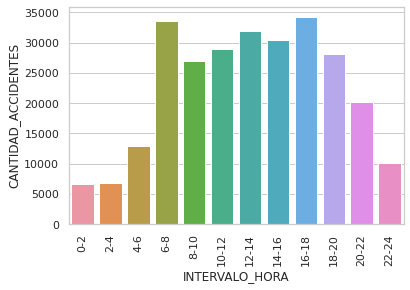

In [ ]:
#Se realiza grafico de intervalo de dos horas
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="INTERVALO_HORA", y="CANTIDAD_ACCIDENTES", data=df_result)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(rotation=90)

In [ ]:
# Se realiza una agrupacion de la cantidad de accidentes por mes y año
dfSumaryAccByMonth = dfMed.groupby(["AÑO","MES"], as_index=False).size()
dfSumaryAccByMonth["AÑO"] = dfSumaryAccByMonth["AÑO"].astype(str)
dfSumaryAccByMonth["MES"] = dfSumaryAccByMonth["MES"].astype(str)
dfSumaryAccByMonth["FECHA_ACCIDENTE"] = dfSumaryAccByMonth["AÑO"] + "-" + dfSumaryAccByMonth["MES"]
dfSumaryAccByMonth = dfSumaryAccByMonth.rename(columns={"size":'CANTIDAD_ACCIDENTES'})
dfSumaryAccByMonth.head(6)

,AÑO,MES,CANTIDAD_ACCIDENTES,FECHA_ACCIDENTE
0,2014,1,668,2014-1
1,2014,2,541,2014-2
2,2014,3,585,2014-3
3,2014,4,704,2014-4
4,2014,5,827,2014-5
5,2014,6,756,2014-6


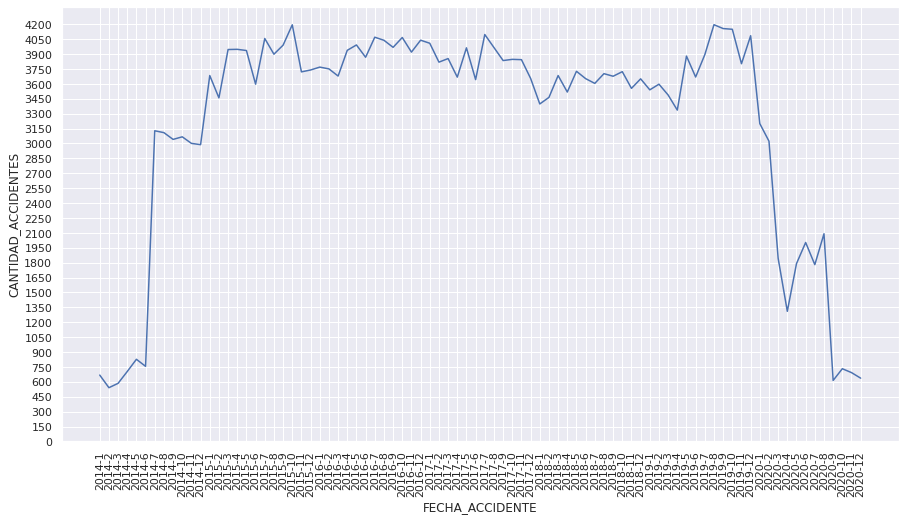

In [ ]:
#Se realiza grafico de la agrupación de la cantidad de accidentes por mes y año
ax = sns.lineplot(x="FECHA_ACCIDENTE", y="CANTIDAD_ACCIDENTES", data=dfSumaryAccByMonth)
plt.yticks(range(0, 4300 , 150))
sns.set(rc = {'figure.figsize':(10,9)})
plt.xticks(rotation=90)
plt.show()

In [ ]:
def getSummaryAccByDayType(df):
  df_result = df.copy()
  df_result =  df_result.groupby(["DIA_ACCIDENTE"], as_index=False).size()
  df_result = df_result.rename(columns={'size':'CANTIDAD_ACCIDENTES'})
  df_result["FR_CANTIDAD_ACCIDENTES %"] = (df_result["CANTIDAD_ACCIDENTES"] / sum(df_result["CANTIDAD_ACCIDENTES"]))*100
  return df_result
  
df_day = getSummaryAccByDayType(dfMed)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

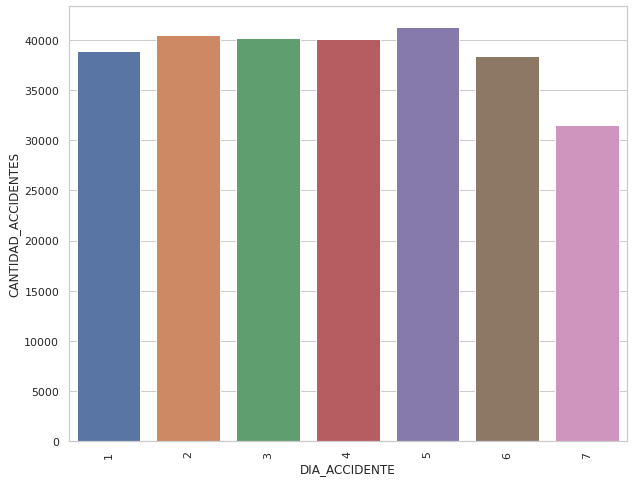

In [ ]:
#Graficar la cantidad de accidentes por dia
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="DIA_ACCIDENTE", y="CANTIDAD_ACCIDENTES", data=df_day)
sns.set(rc = {'figure.figsize':(8,8)})
plt.xticks(rotation=90)

# To PDF

In [ ]:
pip install -U notebook-as-pdf

In [ ]:
pyppeteer-install